In [1]:
import pandas as pd  #pacotes
import numpy as np   #calculo numerico
import glob          #listas
#Codigo para declarar um pyarrow parquet - Willian - 29/05/2018
import pyarrow.parquet as pq
#uproot serve para ler a partir o python um arquivo em tree root
#import uproot
import os, sys
from os import path
import datetime
import matplotlib as mp
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.optimize import curve_fit
%matplotlib inline

## A DIFERENÇA AQUI É A REDUÇÃO DO TEMPO PARA 8 a 30us

In [2]:
%run def_functions.ipynb
%run def_functions_hits.ipynb
%run def_functions_fits.ipynb


In [3]:
'''
list_ON = ['20200824','20200825','20200826','20200827','20200828']
list_OFF = ['20200629','20200630','20200701','20200702','20200703']
list_ONA = ['20200615','20200616','20200617','20200618','20200619']
list_OFF2 = ['20200624','20200625','20200626','20200627','20200628']
list_OFF3 = ['20200704','20200705','20200706','20200707','20200708']
list_OFF4 = ['20200709','20200710','20200711','20200712','20200713']
list_OFF5 = ['20200714','20200715','20200716','20200717','20200718']
list_OFF6 = ['20200719','20200720','20200721','20200722','20200723']
'''

# para 30 dias
list_ON = [
           '20200820','20200821','20200822','20200823','20200824','20200825','20200826',
           '20200827','20200828','20200829','20200830','20200831','20200901','20200902',
           '20200903','20200904','20200905','20200906','20200907','20200908','20200909',
           '20200910','20200911','20200912','20200913','20200924','20200925','20200926',
           '20200927','20200928'
          ]

list_OFF = [
            '20200624','20200625','20200626','20200627','20200628','20200629','20200630',
            '20200701','20200702','20200703','20200704','20200705','20200706','20200707',
            '20200708','20200709','20200710','20200711','20200712','20200713','20200714',
            '20200715','20200716','20200717','20200718','20200719','20200720','20200721',
            '20200722','20200723'
           ]

list_ON2 = [
            '20201001','20201002','20201003','20201004','20201005','20201006','20201007',
            '20201008','20201009','20201010','20201011','20201012','20201013','20201014',
            '20201015','20201016','20201017','20201018','20201019','20201020','20201021',
            '20201022','20201023','20201024','20201025','20201026','20201027','20201028',
            '20201029','20201030'
           ]


In [4]:
#chi_sq_tab = 2.366  # chi quadrado tabelado para 3 graus de liberdades com 50%
#chi_sq_tab = 6.251  # chi quadrado tabelado para 3 graus de liberdades com 90%
chi_sq_tab = 7.815  # chi quadrado tabelado para 3 graus de liberdades com 95%
#chi_sq_tab = 10.597  # chi quadrado tabelado para 3 graus de liberdades com 995%
rh, rw = 150, 150
prompt_mean, prompt_var = 61.45215100965759, 1337.7332240825515
delay_mean, delay_var = 94.3970297029703, 4899.284941672385 
time_mean, time_var = 12.70, 12.70
itime_mean, itime_var = 1/12.70, 1/(12.70**2)

IBD_Esperado = 6610 #eventos por dia


## Função para processar lista

In [7]:
bins_interval = [63.134941, 66.91160302, 70.68826504, 74.46492707, 78.24158909,
 82.01825112, 85.79491314, 89.57157517, 93.34823719, 97.12489922,
 100.90156124, 104.67822326, 108.45488529, 112.23154731, 116.00820934, 
 119.78487136, 123.56153339, 127.33819541, 131.11485744, 134.89151946,
 138.66818149, 142.44484351, 146.22150553, 149.99816756, 153.77482958,
 157.55149161, 161.32815363, 165.10481566, 168.88147768, 172.65813971,
 176.43480173, 180.21146375, 183.98812578, 187.7647878, 191.54144983,
 195.31811185, 199.09477388, 202.8714359, 206.64809793, 210.42475995,
 214.20142197, 217.978084, 221.75474602, 225.53140805, 229.30807007,
 233.0847321, 236.86139412, 240.63805615, 244.41471817, 248.19138019]

#print(bins_interval)

def fnt_search_pos (f_pe):
    arr = [i for i, j in enumerate(bins_interval) if j >= f_pe]
    if len(arr)==0:
        res=-1
    else:
        res = arr[0]
    return res

#print(fnt_search_pos(67))  #2
#print(fnt_search_pos(55))   #0
#print(fnt_search_pos(100))  #10
#print(fnt_search_pos(300))  #-1

In [8]:
def fnt_process_list_PD (p_list, p_h_PDP, p_h_PDD, p_h_PDT, p_h_PD_pPDF, p_list_bins):
    i_day = 0
    p_totalPositrons = 0
    p_totalNonSat = 0
    p_count_bin = [ [] for y in range(len(p_list)) ]
    p_dp_bin = [ [] for y in range(len(p_list)) ]
    p_dpr_bin = [ [] for y in range(len(p_list)) ]                      

    for sListDt in p_list:
        yyyy=int(sListDt[0:4]); mm=int(sListDt[4:6]); dd=int(sListDt[6:8])
    
        sDate = '{0:d}-{1:0>2d}-{2:0>2d}'.format(yyyy,mm,dd)
        sDir='data/{0:d}{1:0>2d}{2:0>2d}'.format(yyyy,mm,dd)
        print(sDir)
        lista = find_interval_date_pair(sDate,sDate,sDir)
        p_h_NonSat = []

        for file in lista:
            df = pd.read_parquet(file)
            dff = df[(df['p_satured']==0)&(df['d_satured']==0)
                            &(fnt_pe2MeV(df['p_Total_pe'])>=3)&(fnt_pe2MeV(df['p_Total_pe'])<=10)
                            &(fnt_pe2MeV(df['d_Total_pe'])>=1.6)&(fnt_pe2MeV(df['d_Total_pe'])<=7.12)
                            &(df['d_timeInverval']>=8)&(df['d_timeInverval']<=30)
                            &(df['d_mPMTs']>=25)
                    ]
            p_h_PDP.extend(dff['p_Total_pe'].values)
            p_h_PDD.extend(dff['d_Total_pe'].values)
            p_h_PDT.extend(dff['d_timeInverval'].values)
            p_h_PD_pPDF.extend(dff['p_PDF'].values)

            dfns = df[(df['p_satured']==0)&(df['d_satured']==0)]

            p_totalPositrons += df.count()[0]
            p_totalNonSat += dfns.count()[0]

            p_h_NonSat.extend(dff['p_Total_pe'].values)            

            #print(p_totalPositrons)
            #break
                
        print('calculando bin')
                      
        p_bin_NonSat = [ [] for y in range(len(p_list_bins)) ]
                      
        ## 1- Navegar na lista de prompt dos eventos filtrados e separá-los em bins de pe
        for iw in range(len(p_h_NonSat)):
            i_b_pos = fnt_search_pos(p_h_NonSat[iw])
            if (i_b_pos!=-1):
                p_bin_NonSat[i_b_pos].append(p_h_NonSat[iw])
        
        ## 2- Navegar na lista de bins e contar quantos eventos ocorreram no dia
        for sb in range(len(p_list_bins)):
            p_count_bin[i_day].append(len(p_bin_NonSat[sb]))

        ## 3- Navegar na lista de bins e calcular o desvio padrao e o desvio padrao medio
        ## não lembro pq fiz em loop separado do anterior - 19/08/2023
        for dpb in range(len(p_list_bins)):
            p_dp_bin[i_day].append(np.std(p_bin_NonSat[dpb]))
            p_dpr_bin[i_day].append(np.std(p_bin_NonSat[dpb])/len(p_bin_NonSat[dpb]))

        i_day += 1
        #break   ## Somente 1 dia de runs

    print('calculando sigmas')
    p_sigma_bin = []
    p_sigmar_bin = []
    p_std_bin = []
    for sbr in range(len(p_list_bins)):
        cday_NSat = []
        cday_Relat = []
        cday_Std = []
        for dd in range(i_day):
            cday_NSat.append(p_count_bin[dd][sbr])
            cday_Relat.append(p_dpr_bin[dd][sbr])
            cday_Std.append(p_dp_bin[dd][sbr])
            
        p_sigma_bin.append(np.sum(cday_NSat)/i_day)  # contagem de eventos/dia dividido pela qtde de dias
        p_sigmar_bin.append(np.sum(cday_Relat)/i_day) # contagem de desvio padrao/dia dividido pela qtde de dias
        p_std_bin.append(np.sum(cday_Std)/i_day) # contagem de desvio padrao relativo/dia (dp/qtde de eventos do bin) dividido pela qtde de dias

    return p_totalPositrons, p_totalNonSat, p_sigma_bin, p_sigmar_bin, p_std_bin


## Processamento para OFF

In [9]:
print('Inicio',datetime.datetime.now())
h_PDP_OFF = []
h_PDD_OFF = []
h_PDT_OFF = []
h_PD_pPDF_OFF = []
totalPositrons_OFF = 0
totalNonSat_OFF = 0
h_Sig_OFF = []
h_SigR_OFF = []
h_Std_OFF = []

totalPositrons_OFF, totalNonSat_OFF, h_Sig_OFF, h_SigR_OFF, h_Std_OFF = fnt_process_list_PD(list_OFF, h_PDP_OFF, h_PDD_OFF, h_PDT_OFF, h_PD_pPDF_OFF, bins_interval)
                            
print(len(h_PDP_OFF))
print(len(h_PDD_OFF))
print(len(h_PDT_OFF))
print('Em ',len(list_OFF),' dias: ',totalPositrons_OFF)
print('Por dia: ',totalPositrons_OFF/len(list_OFF))
print('Em Hz: ',totalPositrons_OFF/len(list_OFF)/86400) 
print('Em ',len(list_OFF),' dias (NS): ',totalNonSat_OFF)
print('Por dia (NS): ',totalNonSat_OFF/len(list_OFF))
print('Em Hz (NS): ',totalNonSat_OFF/len(list_OFF)/86400) 

        
print('Fim',datetime.datetime.now())

Inicio 2023-09-06 17:09:22.576899
data/20200624
calculando bin


C:\Users\RetailAdmin\Anaconda3\lib\site-packages\numpy\core\_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\RetailAdmin\Anaconda3\lib\site-packages\numpy\core\_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\RetailAdmin\Anaconda3\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


data/20200625
calculando bin
data/20200626
calculando bin
data/20200627
calculando bin
data/20200628
calculando bin
data/20200629
calculando bin
data/20200630
calculando bin
data/20200701
calculando bin
data/20200702
calculando bin
data/20200703
calculando bin
data/20200704
calculando bin
data/20200705
calculando bin
data/20200706
calculando bin
data/20200707
calculando bin
data/20200708
calculando bin
data/20200709
calculando bin
data/20200710
calculando bin
data/20200711
calculando bin
data/20200712
calculando bin
data/20200713
calculando bin
data/20200714
calculando bin
data/20200715
calculando bin
data/20200716
calculando bin
data/20200717
calculando bin
data/20200718
calculando bin
data/20200719
calculando bin
data/20200720
calculando bin
data/20200721
calculando bin
data/20200722
calculando bin
data/20200723
calculando bin
calculando sigmas
98098
98098
98098
Em  30  dias:  493463658
Por dia:  16448788.6
Em Hz:  190.37949768518519
Em  30  dias (NS):  317742610
Por dia (NS):  10591

In [10]:
print(h_Sig_OFF)
print(np.sum(h_Sig_OFF))

hg_Sig_OFF = [(x**0.5) for x in h_Sig_OFF]
print(hg_Sig_OFF)

[1.5666666666666667, 317.8666666666667, 295.56666666666666, 278.3666666666667, 260.53333333333336, 229.4, 214.33333333333334, 194.33333333333334, 168.53333333333333, 148.36666666666667, 124.83333333333333, 109.63333333333334, 95.3, 83.83333333333333, 74.16666666666667, 66.83333333333333, 58.06666666666667, 53.0, 46.56666666666667, 43.0, 37.7, 36.266666666666666, 32.233333333333334, 29.433333333333334, 28.133333333333333, 24.166666666666668, 22.933333333333334, 20.433333333333334, 19.1, 15.866666666666667, 14.7, 14.1, 13.0, 11.166666666666666, 10.9, 9.066666666666666, 7.9, 8.066666666666666, 6.4, 6.6, 6.133333333333334, 4.7, 4.033333333333333, 3.933333333333333, 3.7666666666666666, 3.2666666666666666, 3.4, 3.4, 2.2333333333333334, 2.6333333333333333]
3269.7666666666664
[1.2516655570345725, 17.828815627143232, 17.192052427405713, 16.684323979912, 16.141044988888833, 15.145956556124146, 14.6401275039985, 13.940349110884323, 12.982038874280624, 12.180585645471513, 11.172883841396246, 10.47

## Processamento para ON

In [11]:
print('Inicio',datetime.datetime.now())


h_PDP_ON = []
h_PDD_ON = []
h_PDT_ON = []
h_PD_pPDF_ON = []
h_Sig_ON = []
h_SigR_ON = []
h_Std_ON = []

totalPositrons_ON = 0
totalNonSat_ON = 0
i_day = 0

totalPositrons_ON, totalNonSat_ON, h_Sig_ON, h_SigR_ON, h_Std_ON = fnt_process_list_PD(list_ON, h_PDP_ON, h_PDD_ON, h_PDT_ON, h_PD_pPDF_ON, bins_interval)

                            
#print(len(h_P_ON))
#print(len(h_D_ON))
print(len(h_PDP_ON))
print(len(h_PDD_ON))
print(len(h_PDT_ON))
#print('Em ',len(list_OFF),' dias: ',totalPositrons_OFF)
print('Em ',len(list_ON),' dias: ',totalPositrons_ON)
print('Por dia: ',totalPositrons_ON/len(list_ON))
print('Em Hz: ',totalPositrons_ON/len(list_ON)/86400) 
print('Em ',len(list_ON),' dias (NS): ',totalNonSat_ON)
print('Por dia (NS): ',totalNonSat_ON/len(list_ON))
print('Em Hz (NS): ',totalNonSat_ON/len(list_ON)/86400) 

        
print('Fim',datetime.datetime.now())


Inicio 2023-09-06 19:32:34.475815
data/20200820
calculando bin
data/20200821
calculando bin
data/20200822
calculando bin
data/20200823


C:\Users\RetailAdmin\Anaconda3\lib\site-packages\numpy\core\_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\RetailAdmin\Anaconda3\lib\site-packages\numpy\core\_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\RetailAdmin\Anaconda3\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


calculando bin
data/20200824
calculando bin
data/20200825
calculando bin
data/20200826
calculando bin
data/20200827
calculando bin
data/20200828
calculando bin
data/20200829
calculando bin
data/20200830
calculando bin
data/20200831
calculando bin
data/20200901
calculando bin
data/20200902
calculando bin
data/20200903
calculando bin
data/20200904
calculando bin
data/20200905
calculando bin
data/20200906
calculando bin
data/20200907
calculando bin
data/20200908
calculando bin
data/20200909
calculando bin
data/20200910
calculando bin
data/20200911
calculando bin
data/20200912
calculando bin
data/20200913
calculando bin
data/20200924
calculando bin
data/20200925
calculando bin
data/20200926
calculando bin
data/20200927
calculando bin
data/20200928
calculando bin
calculando sigmas
103456
103456
103456
Em  30  dias:  486868739
Por dia:  16228957.966666667
Em Hz:  187.83516165123456
Em  30  dias (NS):  322024815
Por dia (NS):  10734160.5
Em Hz (NS):  124.23796875
Fim 2023-09-06 21:46:11.00230

In [20]:
hg_Sig_ON = [(x**0.5) for x in h_Sig_ON]
print(hg_Sig_ON)

[1.0801234497346435, 18.200732585988582, 18.02498266295976, 17.164886639105234, 16.508583625899995, 15.80506248010428, 15.045486587899598, 14.28402370949213, 13.491972922198345, 12.503332889007368, 11.510864433221338, 10.875047892614848, 10.01332445627658, 9.282600210429546, 8.731170215574389, 8.306623862918075, 7.799572637865061, 7.241086474648216, 6.95221787153807, 6.665833281243488, 6.279596590015423, 5.8423739467217715, 5.8395205282625735, 5.633234713140696, 5.428320796219275, 4.932882862316247, 4.8373546489791295, 4.618802153517006, 4.242640687119285, 4.119061381755152, 4.06201920231798, 3.573047252229764, 3.5683796509527026, 3.6239941133138354, 3.296462750686964, 3.0550504633038935, 3.0659419433511785, 2.701851217221259, 2.581988897471611, 2.54296414970142, 2.2211108331943574, 2.273030282830976, 2.1756225162774294, 2.057506581601462, 2.008316044185609, 2.0976176963403033, 1.8073922282301278, 1.6832508230603465, 1.6532795690182993, 1.51657508881031]


## Processameto ON2 (outubro/2020)

In [13]:
print('Inicio',datetime.datetime.now())


h_PDP_ON2 = []
h_PDD_ON2 = []
h_PDT_ON2 = []
h_PD_pPDF_ON2 = []
h_Sig_ON2 = []
h_SigR_ON2 = []
h_Std_ON2 = []

totalPositrons_ON2 = 0
totalNonSat_ON2 = 0
i_day = 0

totalPositrons_ON2, totalNonSat_ON2, h_Sig_ON2, h_SigR_ON2, h_Std_ON2 = fnt_process_list_PD(list_ON2, h_PDP_ON2, h_PDD_ON2, h_PDT_ON2, h_PD_pPDF_ON2, bins_interval)


print(len(h_PDP_ON2))
print(len(h_PDD_ON2))
print(len(h_PDT_ON2))
print('Em ',len(list_ON2),' dias: ',totalPositrons_ON2)
print('Por dia: ',totalPositrons_ON2/len(list_ON2))
print('Em Hz: ',totalPositrons_ON2/len(list_ON2)/86400) 
print('Em ',len(list_ON2),' dias (NS): ',totalNonSat_ON2)
print('Por dia (NS): ',totalNonSat_ON2/len(list_ON2))
print('Em Hz (NS): ',totalNonSat_ON2/len(list_ON2)/86400) 

        
print('Fim',datetime.datetime.now())


Inicio 2023-09-06 21:46:11.251079
data/20201001
calculando bin
data/20201002
calculando bin
data/20201003
calculando bin
data/20201004


C:\Users\RetailAdmin\Anaconda3\lib\site-packages\numpy\core\_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\RetailAdmin\Anaconda3\lib\site-packages\numpy\core\_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\RetailAdmin\Anaconda3\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


calculando bin
data/20201005
calculando bin
data/20201006
calculando bin
data/20201007
calculando bin
data/20201008
calculando bin
data/20201009
calculando bin
data/20201010
calculando bin
data/20201011
calculando bin
data/20201012
calculando bin
data/20201013
calculando bin
data/20201014
calculando bin
data/20201015
calculando bin
data/20201016
calculando bin
data/20201017
calculando bin
data/20201018
calculando bin
data/20201019
calculando bin
data/20201020
calculando bin
data/20201021
calculando bin
data/20201022
calculando bin
data/20201023
calculando bin
data/20201024
calculando bin
data/20201025
calculando bin
data/20201026
calculando bin
data/20201027
calculando bin
data/20201028
calculando bin
data/20201029
calculando bin
data/20201030
calculando bin
calculando sigmas
104858
104858
104858
Em  30  dias:  472407363
Por dia:  15746912.1
Em Hz:  182.25592708333332
Em  30  dias (NS):  312322106
Por dia (NS):  10410736.866666667
Em Hz (NS):  120.49463966049383
Fim 2023-09-06 23:57:10

In [14]:
hg_Sig_ON2 = [(x**0.5) for x in h_Sig_ON2]
print(hg_Sig_ON2)

[1.1254628677422756, 18.374801586230348, 18.050854088749745, 17.386776584519627, 16.85922101798696, 15.864005379054392, 15.188811671753653, 14.232591705893437, 13.42013412749664, 12.45391504708459, 11.630419883506644, 10.79814798935447, 10.084641788382967, 9.4798030921885, 8.799621203968574, 8.328665359267754, 7.756717518813397, 7.536577472566709, 7.0379921379135775, 6.638272867747052, 6.3744280789207535, 6.212889826803627, 5.805170109479997, 5.4984846397287805, 5.221749387577564, 5.066228051190222, 4.792355023020171, 4.568004670166906, 4.285634919900045, 4.070217029430577, 3.9370039370059056, 3.8297084310253524, 3.63318042491699, 3.391164991562634, 3.366501646120693, 3.1144823004794873, 3.03315017762062, 2.9097537123726926, 2.54296414970142, 2.569046515733026, 2.442676128074835, 2.359378449224852, 2.265686062395524, 2.1525179054617256, 1.9748417658131499, 2.0896570691543306, 1.7795130420052185, 1.8073922282301278, 1.6832508230603465, 1.559914527573012]


## Resultado Final

## Salvar e carregar Listas ON / OFF

In [15]:
##save values - h_Sig_OFF2 (contém o sigma de cada bin dividido por 5dias)
def save_PD (dh_PDP, dh_PDD, dh_PDT, dh_Sig, sName):
    # dictionary of lists
    dict = {'dh_PDP': dh_PDP,
            'dh_PDD': dh_PDD,
            'dh_PDT': dh_PDT}
    
    dict2 = {'dh_Sig': dh_Sig}
 
    # creating a dataframe from dictionary
    dfw = pd.DataFrame(dict)
    dfw.to_parquet('data/Analise_ONOFF/'+sName+'.parq', compression='gzip')

    dfw2 = pd.DataFrame(dict2)
    dfw2.to_parquet('data/Analise_ONOFF/Sig_'+sName+'.parq', compression='gzip')

    del dict2
    del dict
    
##load values
def load_PD (sName): #(dh_PDP, dh_PDD, dh_PDT, dh_Sig, sName):
    dfr = pd.read_parquet('data/Analise_ONOFF/'+sName+'.parq')
    dfr2 = pd.read_parquet('data/Analise_ONOFF/Sig_'+sName+'.parq')
    return(dfr['dh_PDP'].values, dfr['dh_PDD'].values, dfr['dh_PDT'].values, dfr2['dh_Sig'].values)

    

In [21]:
i_day = 30

hg_Sig_ON = [((x*i_day)**0.5) for x in h_Sig_ON]     ## x é a quantidade do bin / quantidade de dias 
hg_Sig_ON2 = [((x*i_day)**0.5) for x in h_Sig_ON2]     ## x é a quantidade do bin / quantidade de dias 
hg_Sig_OFF = [((x*i_day)**0.5) for x in h_Sig_OFF] 

In [17]:
save_PD (h_PDP_ON, h_PDD_ON, h_PDT_ON, hg_Sig_ON, 'PD_ON_30_3s')  # 3s equivalente ao filtro de tempo 3sigma (8us a 30us) 
save_PD (h_PDP_ON2, h_PDD_ON2, h_PDT_ON2, hg_Sig_ON2, 'PD_ON2_30_3s')   # 07/09/2023
save_PD (h_PDP_OFF, h_PDD_OFF, h_PDT_OFF, hg_Sig_OFF, 'PD_OFF_30_3s')


In [9]:
h_PDP_ONT=[]
h_PDD_ONT=[]
h_PDT_ONT=[]
hg_Sig_ONT=[]

h_PDP_ONT, h_PDP_ONT, h_PDP_ONT, hg_Sig_ONT = load_PD ('PD_ON')

## Plot genérico por atribuição

In [29]:
i_day = 30
#histd_ON, binsd_ON = np.histogram(h_PDP_ON, bins=maxElement, normed= True)


## gnh_PDP_ON: primeiro set genérico de valores (pode ser um set OFF)
#gnh_PDP_ON = h_PDP_OFF
#gnh_Sig_ON = hg_Sig_OFF #[((x*i_day)**0.5) for x in hg_Sig_ON]
gnh_PDP_ON = h_PDP_ON
gnh_Sig_ON = hg_Sig_ON #[((x*i_day)**0.5) for x in hg_Sig_ON]

#ls_dataI = list_OFF[0]
#ls_dataF = list_OFF[4]
ls_dataI = list_ON[0]
ls_dataF = list_ON[29]

tl_set1 = 'ON ('+ls_dataI[6:8]+'/'+ls_dataI[4:6]+'/'+ls_dataI[0:4]+' a '+ls_dataF[6:8]+'/'+ls_dataF[4:6]+'/'+ls_dataF[0:4]+')'
print(tl_set1)

## gnh_PDP_ON: segundo set genérico de valores que será retirado do primeiro (pode ser outro set OFF)
gnh_PDP_OFF = h_PDP_OFF
gnh_Sig_OFF = hg_Sig_OFF #[((x*i_day)**0.5) for x in hg_Sig_OFF5]
#gnh_PDP_OFF = h_PDP_OFF
#gnh_Sig_OFF = hg_Sig_OFF #[((x*i_day)**0.5) for x in hg_Sig_OFF5]

#ls_dataI = list_OFF6[0]
#ls_dataF = list_OFF6[4]
ls_dataI = list_OFF[0]
ls_dataF = list_OFF[29]

tl_set2 = 'OFF ('+ls_dataI[6:8]+'/'+ls_dataI[4:6]+'/'+ls_dataI[0:4]+' a '+ls_dataF[6:8]+'/'+ls_dataF[4:6]+'/'+ls_dataF[0:4]+')'
print(tl_set2)

maxElement = int(np.amax(gnh_PDP_OFF)/5)

errbar_sigma_day = []
for inf in range(len(gnh_Sig_OFF)):
    errbar_sigma_day.append((gnh_Sig_OFF[inf]**2 + gnh_Sig_ON[inf]**2)**0.5)


ON (20/08/2020 a 28/09/2020)
OFF (24/06/2020 a 23/07/2020)


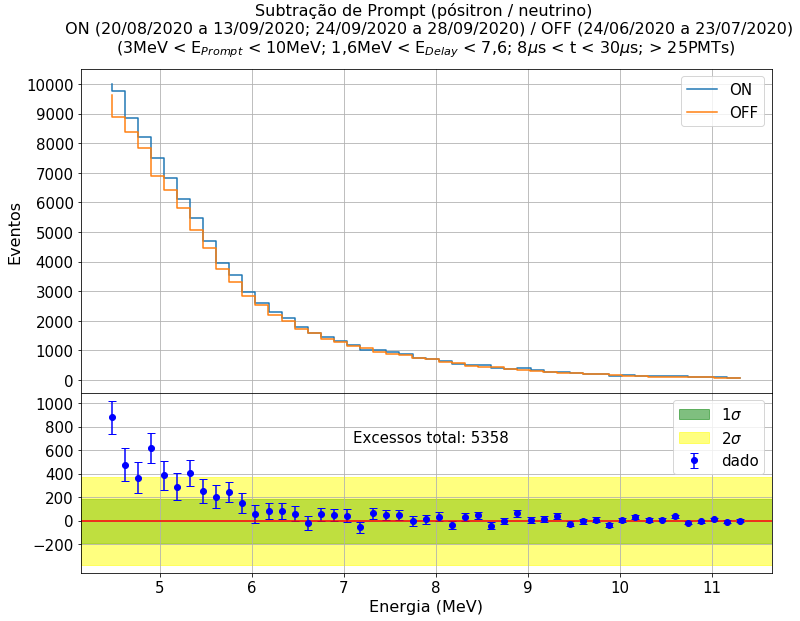

Excessos total
5358
Excessos até 7MeV
5035
Excessos até 6,5MeV
4953


In [30]:


fig=plt.figure(figsize=(12,5))

plt.rcParams.update({'font.size': 15})


hist1_ON, bins1_ON = np.histogram(gnh_PDP_ON, bins=maxElement)
hist1_OFF, bins1_OFF = np.histogram(gnh_PDP_OFF, bins=maxElement)

diff_hist = hist1_ON - hist1_OFF  # somente com prompt que está relacionado com a energia do neutrino
diff_hist2 = np.append(diff_hist, [0])

#print(fnt_Positron2Neutrino(fnt_pe2MeV(bins1_OFF)),hist1_OFF)

axprops = dict(yticks=[])
axs = []

axs.append(fig.add_axes([0.1, 1.0, 0.8, 0.9], **axprops))
axs.append(fig.add_axes([0.1, 0.5, 0.8, 0.5], **axprops))

axs[0].plot(fnt_Positron2Neutrino(fnt_pe2MeV(bins1_ON[1:])),hist1_ON, '-', drawstyle='steps', label='ON') ##bins1_ON possui um elemento a mais sempre
axs[0].plot(fnt_Positron2Neutrino(fnt_pe2MeV(bins1_OFF[1:])),hist1_OFF, '-', drawstyle='steps', label='OFF') 
axs[1].errorbar(fnt_Positron2Neutrino(fnt_pe2MeV(bins1_OFF[1:])),diff_hist2[1:], yerr=errbar_sigma_day[1:] , marker='o', color='blue', 
             linestyle='None', capsize=4, label='dado')

axs[0].grid(True)
axs[1].grid(True)

axs[1].axhline(0,color='red')

axs[1].axhspan(np.std(diff_hist2), np.std(diff_hist2)*-1, color='green', alpha=0.5, label=r'1$\sigma$')
axs[1].axhspan(np.std(diff_hist2)*2, np.std(diff_hist2)*-2, color='yellow', alpha=0.5, label=r'2$\sigma$')

axs[0].legend(loc='upper right')
axs[1].legend(loc='upper right')
axs[0].set_ylabel('Eventos', size=16)
axs[1].set_xlabel('Energia (MeV)', size=16)
axs[0].set_yticks(np.arange(0, 11000, 1000))
axs[1].set_yticks(np.arange(-200, 1200, 200))

tl_set1 = 'ON (20/08/2020 a 13/09/2020; 24/09/2020 a 28/09/2020)'

axs[0].set_title('Subtração de Prompt (pósitron / neutrino) \n '+
                 tl_set1+' / '+
                 tl_set2+'\n'+
                 r'(3MeV < E$_{Prompt}$ < 10MeV; 1,6MeV < E$_{Delay}$ < 7,12MeV; 8$\mu$s < t < 30$\mu$s; > 25PMTs)', size=16,y=1.02)

axs[1].annotate('Excessos total: {:d}'.format(sum(diff_hist2)), xy=(7.1, 670))
#plt.savefig('histogramas/Hist_PD_ON_X_OFF_Subtrac_updown.png')
plt.show()

print('Excessos total')
print(sum(diff_hist2))
print('Excessos até 7MeV')
print(sum(diff_hist2[:19]))
print('Excessos até 6,5MeV')
print(sum(diff_hist2[:16]))


In [87]:
histP_ON, binsP_ON = np.histogram(h_PDP_ON, bins=maxElement)
histP_ON2, binsP_ON2 = np.histogram(h_PDP_ON2, bins=maxElement)
histP_OFF, binsP_OFF = np.histogram(h_PDP_OFF, bins=maxElement)

#print('\n\ncontagem ON:\n', histP_ON,'\nbins ON:\n',fnt_pe2MeV(binsP_ON))
#print('\n\ncontagem ON2:\n', histP_ON2,'\nbins ON2:\n',binsP_ON2)
#print('\n\ncontagem OFF:\n', histP_OFF,'\nbins OF:\n',binsP_OFF)
print('\n\ncontagem ON:\n', histP_ON)
print('\n\ncontagem ON2:\n', histP_ON2)
print('\n\ncontagem OFF:\n', histP_OFF)

print('\n\nbins (EM FOTOELETRONS DO POSITRON - pe):\n',binsP_ON)
print('\nbins (EM ENERGIA DO POSITRON - MeV):\n',fnt_pe2MeV(binsP_ON))
print('\nbins (EM ENERGIA DO ANTINEUTRINO - MeV):\n',fnt_Positron2Neutrino(fnt_pe2MeV(bins1_ON)))



contagem ON:
 [12598 12144 11144 10313  9451  8498  7633  6877  5935  5043  4505  3820
  3315  2902  2681  2306  2055  1885  1711  1500  1318  1306  1230  1185
   972   906   823   734   662   651   551   489   509   455   386   371
   315   269   267   209   219   215   177   165   186   139   133   123
    94]


contagem ON2:
 [12835 12232 11345 10631  9410  8712  7588  6774  5844  5084  4369  3818
  3419  2960  2663  2364  2180  1921  1747  1608  1457  1311  1189  1114
   990   916   826   717   656   638   589   539   467   459   404   374
   336   268   282   243   232   224   173   176   163   142   123   116
   113]


contagem OFF:
 [12089 11234 10514  9850  8746  8065  7333  6386  5645  4809  4219  3626
  3207  2833  2611  2259  2023  1846  1641  1484  1406  1225  1181  1085
   948   900   790   769   648   622   583   499   442   418   362   341
   330   278   254   257   211   175   163   150   140   150   120   104
   102]


bins (EM FOTOELETRONS DO POSITRON - pe):
 [ 63.1

In [92]:
print('Prompt: ')
print(fnt_DUQ2MeV(785))
print(fnt_DUQ2MeV(13200))
print(fnt_DUQ2MeV(5000))
print(fnt_DUQ2MeV(11000))

Prompt: 
0.99994
7.0088
3.04
5.944


In [27]:
i_day = 30
#histd_ON, binsd_ON = np.histogram(h_PDP_ON, bins=maxElement, normed= True)


## gnh_PDP_ON: primeiro set genérico de valores (pode ser um set OFF)
#gnh_PDP_ON = h_PDP_OFF
#gnh_Sig_ON = hg_Sig_OFF #[((x*i_day)**0.5) for x in hg_Sig_ON]
gnh_PDP_ON = h_PDP_ON2
gnh_Sig_ON = hg_Sig_ON2 #[((x*i_day)**0.5) for x in hg_Sig_ON]

#ls_dataI = list_OFF[0]
#ls_dataF = list_OFF[4]
ls_dataI = list_ON2[0]
ls_dataF = list_ON2[29]

tl_set1 = 'ON2 ('+ls_dataI[6:8]+'/'+ls_dataI[4:6]+'/'+ls_dataI[0:4]+' a '+ls_dataF[6:8]+'/'+ls_dataF[4:6]+'/'+ls_dataF[0:4]+')'
print(tl_set1)

## gnh_PDP_ON: segundo set genérico de valores que será retirado do primeiro (pode ser outro set OFF)
gnh_PDP_OFF = h_PDP_OFF
gnh_Sig_OFF = hg_Sig_OFF #[((x*i_day)**0.5) for x in hg_Sig_OFF5]
#gnh_PDP_OFF = h_PDP_OFF
#gnh_Sig_OFF = hg_Sig_OFF #[((x*i_day)**0.5) for x in hg_Sig_OFF5]

#ls_dataI = list_OFF6[0]
#ls_dataF = list_OFF6[4]
ls_dataI = list_OFF[0]
ls_dataF = list_OFF[29]

tl_set2 = 'OFF ('+ls_dataI[6:8]+'/'+ls_dataI[4:6]+'/'+ls_dataI[0:4]+' a '+ls_dataF[6:8]+'/'+ls_dataF[4:6]+'/'+ls_dataF[0:4]+')'
print(tl_set2)

maxElement = int(np.amax(gnh_PDP_OFF)/5)

errbar_sigma_day = []
for inf in range(len(gnh_Sig_OFF)):
    errbar_sigma_day.append((gnh_Sig_OFF[inf]**2 + gnh_Sig_ON[inf]**2)**0.5)


ON2 (01/10/2020 a 30/10/2020)
OFF (24/06/2020 a 23/07/2020)


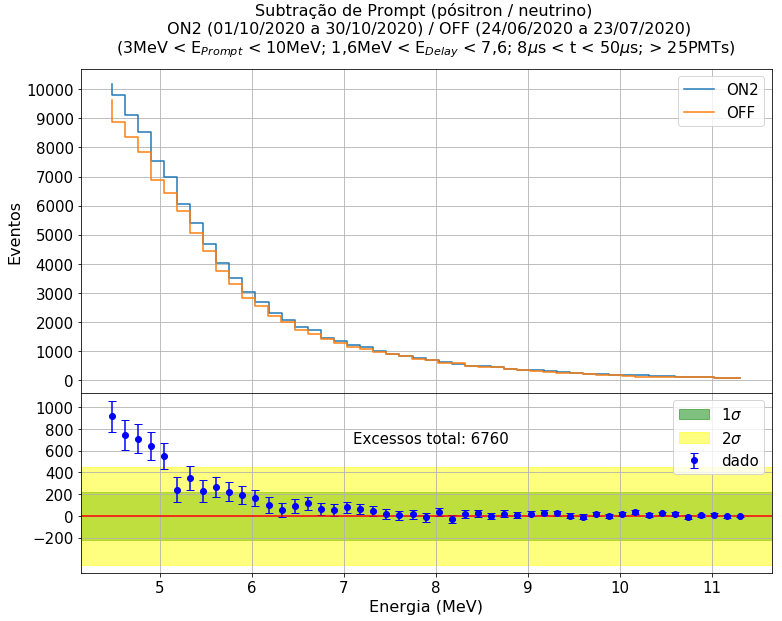

Excessos total
6760
Excessos até 7MeV
6277
Excessos até 6,5MeV
6047


In [28]:


fig=plt.figure(figsize=(12,5))

plt.rcParams.update({'font.size': 15})


hist1_ON, bins1_ON = np.histogram(gnh_PDP_ON, bins=maxElement)
hist1_OFF, bins1_OFF = np.histogram(gnh_PDP_OFF, bins=maxElement)

diff_hist = hist1_ON - hist1_OFF  # somente com prompt que está relacionado com a energia do neutrino
diff_hist2 = np.append(diff_hist, [0])

#print(fnt_Positron2Neutrino(fnt_pe2MeV(bins1_OFF)),hist1_OFF)

axprops = dict(yticks=[])
axs = []

axs.append(fig.add_axes([0.1, 1.0, 0.8, 0.9], **axprops))
axs.append(fig.add_axes([0.1, 0.5, 0.8, 0.5], **axprops))

axs[0].plot(fnt_Positron2Neutrino(fnt_pe2MeV(bins1_ON[1:])),hist1_ON, '-', drawstyle='steps', label='ON2') ##bins1_ON possui um elemento a mais sempre
axs[0].plot(fnt_Positron2Neutrino(fnt_pe2MeV(bins1_OFF[1:])),hist1_OFF, '-', drawstyle='steps', label='OFF') 
axs[1].errorbar(fnt_Positron2Neutrino(fnt_pe2MeV(bins1_OFF[1:])),diff_hist2[1:], yerr=errbar_sigma_day[1:] , marker='o', color='blue', 
             linestyle='None', capsize=4, label='dado')

axs[0].grid(True)
axs[1].grid(True)

axs[1].axhline(0,color='red')

axs[1].axhspan(np.std(diff_hist2), np.std(diff_hist2)*-1, color='green', alpha=0.5, label=r'1$\sigma$')
axs[1].axhspan(np.std(diff_hist2)*2, np.std(diff_hist2)*-2, color='yellow', alpha=0.5, label=r'2$\sigma$')

axs[0].legend(loc='upper right')
axs[1].legend(loc='upper right')
axs[0].set_ylabel('Eventos', size=16)
axs[1].set_xlabel('Energia (MeV)', size=16)
axs[0].set_yticks(np.arange(0, 11000, 1000))
axs[1].set_yticks(np.arange(-200, 1200, 200))

#tl_set1 = 'ON (20/08/2020 a 13/09/2020; 24/09/2020 a 28/09/2020)'

axs[0].set_title('Subtração de Prompt (pósitron / neutrino) \n '+
                 tl_set1+' / '+
                 tl_set2+'\n'+
                 r'(3MeV < E$_{Prompt}$ < 10MeV; 1,6MeV < E$_{Delay}$ < 7,12MeV; 8$\mu$s < t < 50$\mu$s; > 25PMTs)', size=16,y=1.02)

axs[1].annotate('Excessos total: {:d}'.format(sum(diff_hist2)), xy=(7.1, 670))
#plt.savefig('histogramas/Hist_PD_ON_X_OFF_Subtrac_updown.png')
plt.show()

print('Excessos total')
print(sum(diff_hist2))
print('Excessos até 7MeV')
print(sum(diff_hist2[:19]))
print('Excessos até 6,5MeV')
print(sum(diff_hist2[:16]))
